In [1]:
import warnings
warnings.filterwarnings('ignore')

import torch
import linear_rep_geometry as lrg
import os
import numpy as np
import matplotlib.pyplot as plt
import transformers
import matplotlib.gridspec as gridspec
import re

In [2]:
device_id = 2
device = torch.device(f"cuda:{device_id}")

g = torch.load('tmp_matrices/g.pt').to(device)
concept_g = torch.load('tmp_matrices/concept_g.pt').to(device)
sqrt_Cov_gamma = torch.load("tmp_matrices/sqrt_Cov_gamma.pt").to(device)
W, d = g.shape

concept_names = []
with open('tmp_matrices/concept_names.txt', 'r') as f:
    for line in f.readlines():
        concept_names.append(line.strip())

In [3]:
device_id=2
model_path = "meta-llama/Llama-3.2-3B-Instruct"
device = torch.device(f"cuda:{device_id}")

tokenizer = transformers.AutoTokenizer.from_pretrained(model_path, use_fast=False)
tokenizer.pad_token = tokenizer.eos_token
model = transformers.AutoModelForCausalLM.from_pretrained(
    model_path,
    device_map={"": device},
)
model = model.to(device)

Loading checkpoint shards: 100%|██████████| 2/2 [00:01<00:00,  1.29it/s]


In [4]:
# 価値観の種類を取得
filenames = []
with open(f"tmp_matrices/filenames.txt", "r") as f:
    for line in f.readlines():
        filenames.append(line.strip())

concept2idx = {}
idx2concept = {}
pattern = r'\[(.*?)\('
for idx, filename in enumerate(filenames):
    match1 = re.search(pattern, filenames[idx].split("/")[-1])
    concept_name = match1.group(1)
    concept2idx[concept_name] = idx
    idx2concept[idx] = concept_name
concept2idx

{'Achievement': 0,
 'Benevolence': 1,
 'Conformity': 2,
 'Hedonism': 3,
 'Power': 4,
 'Security': 5,
 'Self-direction': 6,
 'Stimulation': 7,
 'Tradition': 8,
 'Universalism': 9}

In [8]:
import torch
import torch.nn.functional as F

# --- Initial Setup --- #
intervention_value_name = "Benevolence"
intervention_value_idx = concept2idx[intervention_value_name]
concept_vec = concept_g[intervention_value_idx]

# --- Prepare Input Text --- #
neutral_texts = [
    "The person completed the task.",
    "They made a decision about the matter.",
    "The group discussed the situation.",
    "telling my friend that it will take 7 years for her to graduate with her double major",
    "My colleague is quitting her job."
]

text = neutral_texts[0]
prompt = f"Please write a natural continuation following this text:\n{text}"
# prompt = f"{text}"

# --- Parameter Settings --- #
ALPHA = 0.0
N_GENERATE_TOKENS = 32
temperature = 0.8
top_p = 0.95
verbose = False

# --- Configuration --- #
if verbose:
    print("\n=== Experiment Configuration ===")
    print(f"Target Concept: {intervention_value_name}")
    print(f"Intervention Strength α: {ALPHA}")
    print(f"Number of Generated Tokens: {N_GENERATE_TOKENS}")
    print(f"Temperature: {temperature}")
    print(f"Top-p: {top_p}")

    print("\n=== Input Prompt ===")
    print(prompt)
    print("=" * 50)

# --- Tokenization --- #
encoded = tokenizer(
    prompt,
    padding=True,
    truncation=True,
    return_tensors="pt",
    return_attention_mask=True,
    max_length=128,
).to(device)

input_ids = encoded.input_ids          # (1, seq_len)
attention_mask = encoded.attention_mask
max_length = input_ids.shape[1] + N_GENERATE_TOKENS

# --- Generation Process --- #
# print("\nStarting text generation...")

generated_ids = input_ids  # (1, seq_len)

for _ in range(N_GENERATE_TOKENS):
    with torch.no_grad():
        # 1) モデルに通す
        outputs = model(
            generated_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )

        # 2) 最終層の隠れ状態を取得 → 最後のトークン位置のベクトルを抜き出す
        last_hidden_state = outputs.hidden_states[-1]       # (1, seq_len, hidden_dim)
        last_token_state = last_hidden_state[:, -1, :]      # (1, hidden_dim)

        # 3) intervention (ALPHA=0 なら変化なし)
        intervened_state = last_token_state + ALPHA * concept_vec  # (1, hidden_dim)

        # 4) 次トークンのロジットを計算
        logits = model.lm_head(intervened_state)  # (1, vocab_size)
        
        # 5) top-p サンプリングを適用 (バッチサイズ1想定の簡易実装)
        # 5-1) temperature を適用
        scaled_logits = logits[0] / temperature  # => (vocab_size,) for batch=1

        # 5-2) ソート (降順)
        sorted_logits, sorted_indices = torch.sort(scaled_logits, descending=True)
    
        # 5-3) softmax → 累積確率を計算
        sorted_probs = F.softmax(sorted_logits, dim=-1)
        cumulative_probs = torch.cumsum(sorted_probs, dim=-1)  # 累積確率

        # 5-4) top_p を超えたものを除去する (確率を0扱いにする)
        #      Trueの箇所を -inf にする
        sorted_indices_to_remove = cumulative_probs > top_p
        # 先頭トークン(一番確率高い)は除外しないようにシフト
        sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
        sorted_indices_to_remove[0] = False

        # マスクをかける (top_p を超えたトークンを -inf にする)
        sorted_logits[sorted_indices_to_remove] = float('-inf')

        # 元の順序に戻す
        # scatter_ などを使って、ソート前の logits の位置を更新
        probs_to_sample = torch.zeros_like(scaled_logits)
        probs_to_sample[sorted_indices] = sorted_logits
        
        # softmax し直して確率分布を得る
        final_probs = F.softmax(probs_to_sample, dim=-1)

        # 5-5) サンプリング
        next_token_id = torch.multinomial(final_probs, num_samples=1)  # shape=(1,)

    # 6) 生成系列を更新
    next_token_id = next_token_id.unsqueeze(0)  # shape=(1,1)
    generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)

    # attention_mask も更新
    attention_mask = torch.cat(
        [attention_mask, torch.ones((attention_mask.shape[0], 1), device=device)],
        dim=-1,
    )

# --- Decode the generated tokens --- #
generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
original_prompt = tokenizer.decode(input_ids[0], skip_special_tokens=True)
continuation = generated_text[len(original_prompt):].strip()

# print("\n=== Generation Results ===")
print(original_prompt)
print("->")
print(text + " " + continuation)


Please write a natural continuation following this text:
The person completed the task.
->
The person completed the task. Now, they're left with a satisfied feeling, a sense of accomplishment that they've managed to accomplish something they thought was impossible. The sun is shining, the


In [11]:
import torch
import torch.nn.functional as F
import os
import numpy as np
from typing import List, Dict, Union, Optional
from torch import Tensor, device as torch_device

def run_intervention(
    model: torch.nn.Module,
    tokenizer: Union[torch.nn.Module, object],
    texts: List[str],
    concept_g: Tensor,
    concept2idx: Dict[str, int],
    intervention_value_name: str = "Achievement",
    min_alpha: float = 0.0,
    max_alpha: float = 1.0,
    step_alpha: float = 0.1,
    n_generate_tokens: int = 32,
    temperature: float = 0.8,
    top_p: float = 0.95,
    device: torch_device = "cuda",
    verbose: bool = False,
    save_output: bool = True
) -> np.ndarray:
    intervention_value_idx = concept2idx[intervention_value_name]
    concept_vec = concept_g[intervention_value_idx]
    alphas = np.arange(min_alpha, max_alpha + step_alpha, step_alpha)
    
    if save_output:
        os.makedirs("intervention", exist_ok=True)
        output_path = os.path.join("intervention", f"{intervention_value_name}.md")
        with open(output_path, "w", encoding="utf-8") as f:
            f.write(f"# {intervention_value_name}\n\n")

    for alpha in alphas:
        results = []
        for text in texts:
            prompt = f"Please write a natural continuation following this text:\n{text}"
            encoded = tokenizer(
                prompt,
                padding=True,
                truncation=True,
                return_tensors="pt",
                return_attention_mask=True,
                max_length=128,
            ).to(device)

            input_ids = encoded.input_ids
            attention_mask = encoded.attention_mask
            generated_ids = input_ids

            for _ in range(n_generate_tokens):
                with torch.no_grad():
                    outputs = model(
                        generated_ids,
                        attention_mask=attention_mask,
                        output_hidden_states=True
                    )
                    
                    last_hidden_state = outputs.hidden_states[-1]
                    last_token_state = last_hidden_state[:, -1, :]
                    intervened_state = last_token_state + alpha * concept_vec
                    logits = model.lm_head(intervened_state)
                    
                    scaled_logits = logits[0] / temperature
                    sorted_logits, sorted_indices = torch.sort(scaled_logits, descending=True)
                    sorted_probs = F.softmax(sorted_logits, dim=-1)
                    cumulative_probs = torch.cumsum(sorted_probs, dim=-1)
                    
                    sorted_indices_to_remove = cumulative_probs > top_p
                    sorted_indices_to_remove[1:] = sorted_indices_to_remove[:-1].clone()
                    sorted_indices_to_remove[0] = False
                    sorted_logits[sorted_indices_to_remove] = float('-inf')
                    
                    probs_to_sample = torch.zeros_like(scaled_logits)
                    probs_to_sample[sorted_indices] = sorted_logits
                    final_probs = F.softmax(probs_to_sample, dim=-1)
                    
                    next_token_id = torch.multinomial(final_probs, num_samples=1).unsqueeze(0)
                    
                    generated_ids = torch.cat([generated_ids, next_token_id], dim=-1)
                    attention_mask = torch.cat(
                        [attention_mask, torch.ones((attention_mask.shape[0], 1), device=device)],
                        dim=-1,
                    )

            generated_text = tokenizer.decode(generated_ids[0], skip_special_tokens=True)
            original_prompt = tokenizer.decode(input_ids[0], skip_special_tokens=True)
            continuation = generated_text[len(original_prompt):].strip()
            full_text = text + " " + continuation
            
            results.append({
                "original": text,
                "interventioned": full_text
            })

            if verbose:
                print(f"Alpha: {alpha:.1f}, Text: {text}")
                print(f"Generated: {full_text}")

        if save_output:
            with open(output_path, "a", encoding="utf-8") as f:
                f.write(f"\n## α = {alpha:.1f}\n\n")
                for i, result in enumerate(results, 1):
                    f.write(f"### Text {i}\n")
                    f.write(f"**Original**: {result['original']}\n\n")
                    f.write(f"**Interventioned**: {result['interventioned']}\n\n")
                f.write("---\n")
    print("Complete All Generation.")

In [13]:
device_id = 2
device = torch.device(f"cuda:{device_id}")

neutral_texts = [
    "The person completed the task.",
    "They made a decision about the matter.",
    "The group discussed the situation.",
    "telling my friend that it will take 7 years for her to graduate with her double major",
    "My colleague is quitting her job."
]

for value_name in concept2idx.keys():
    print(f"Value Name: {value_name}")
    run_intervention(
        model=model,
        tokenizer=tokenizer,
        texts=neutral_texts,
        concept_g=concept_g,
        concept2idx=concept2idx,
        intervention_value_name=value_name,
        min_alpha=0.0,
        max_alpha=1.0,
        step_alpha=0.1,
        n_generate_tokens=64,
        temperature=0.9,
        top_p=0.95,
        device=device,
        verbose=False,
        save_output=True
    )

Value Name: Achievement


KeyboardInterrupt: 

# 雑な検証

In [ ]:
from typing import Dict, Tuple, Union
import torch
from torch import Tensor
from torch.nn import Module
from transformers import PreTrainedTokenizer

def generate_text_with_concept_intervention(
    model: Module,
    tokenizer: PreTrainedTokenizer,
    concept_g: Tensor,
    concept2idx: Dict[str, int],
    intervention_value_name: str,
    text: str,
    alpha: float = 0.1,
    n_generate_tokens: int = 32,
    temperature: float = 0.8,
    top_p: float = 0.95,
    device: str = "cuda",
    verbose: bool = True
) -> Tuple[str, str, str]:
    """
    Generate text with concept intervention.
    
    Args:
        model (Module): The language model
        tokenizer (PreTrainedTokenizer): The tokenizer
        concept_g (Tensor): Concept embeddings
        concept2idx (Dict[str, int]): Dictionary mapping concept names to indices
        intervention_value_name (str): Name of the concept to intervene with
        text (str): Input text for continuation
        alpha (float): Intervention strength
        n_generate_tokens (int): Number of tokens to generate
        temperature (float): Sampling temperature
        top_p (float): Top-p sampling parameter
        device (str): Device to run the model on
        verbose (bool): Whether to print configuration and results
        
    Returns:
        Tuple[str, str, str]: Tuple containing (original_text, continuation_text, full_generated_text)
    """
    # --- Initial Setup --- #
    intervention_value_idx: int = concept2idx[intervention_value_name]
    concept_vec: Tensor = concept_g[intervention_value_idx]

    # --- Prepare Input Text --- #
    prompt: str = f"Below is a continuation of the sentence. Write a natural continuation:\n{text}\n\nContinuation:"

    # --- Configuration Output --- #
    if verbose:
        print("\n=== Experiment Configuration ===")
        print(f"Target Concept: {intervention_value_name}")
        print(f"Intervention Strength α: {alpha}")
        print(f"Number of Generated Tokens: {n_generate_tokens}")
        print(f"Temperature: {temperature}")
        print(f"Top-p: {top_p}")
        print("\n=== Input Prompt ===")
        print(prompt)
        print("=" * 50)

    # --- Tokenization --- #
    encoded = tokenizer(
        prompt,
        padding=True,
        truncation=True,
        return_tensors="pt",
        return_attention_mask=True,
        max_length=128,
    ).to(device)

    input_ids: Tensor = encoded.input_ids
    attention_mask: Tensor = encoded.attention_mask
    max_length: int = input_ids.shape[1] + n_generate_tokens

    # --- Generation Process --- #
    if verbose:
        print("\nStarting text generation...")
        
    with torch.no_grad():
        # Get original embeddings
        outputs = model(
            input_ids,
            attention_mask=attention_mask,
            output_hidden_states=True
        )
        last_hidden_state: Tensor = outputs.hidden_states[-1]
        masked_hidden_state: Tensor = last_hidden_state * attention_mask.unsqueeze(-1)
        sum_hidden_state: Tensor = masked_hidden_state.sum(dim=1)
        count_tokens: Tensor = attention_mask.sum(dim=1).unsqueeze(-1)
        original_embedding: Tensor = sum_hidden_state / count_tokens

        # Concept intervention
        intervened_embedding: Tensor = original_embedding + alpha * concept_vec

        # Generation parameters
        gen_kwargs: Dict[str, Union[int, bool, float]] = {
            "max_length": max_length,
            "num_return_sequences": 1,
            "do_sample": True,
            "top_p": top_p,
            "temperature": temperature,
            "pad_token_id": tokenizer.pad_token_id,
            "eos_token_id": tokenizer.eos_token_id,
        }
        
        # Text generation
        outputs: Tensor = model.generate(
            input_ids,
            **gen_kwargs,
        )

    # --- Process Results --- #
    generated_text: str = tokenizer.decode(outputs[0], skip_special_tokens=True)
    original_prompt: str = tokenizer.decode(input_ids[0], skip_special_tokens=True)
    continuation: str = generated_text[len(original_prompt):].strip()

    if verbose:
        print("\n=== Generation Results ===")
        print(text + " " + continuation)

    return text, continuation, text + " " + continuation

In [2]:
def analyze_value_intervention(
    text_batch,           # 中立的な文章のバッチ
    model,               # 言語モデル
    tokenizer,           # トークナイザー
    concept_vectors,     # 価値観のconceptベクトル
    value_names,         # 価値観の名前リスト（例：["Achievement", "Power", ...]）
    alpha=0.5,          # 介入の強度
    top_k=5,            # 表示する上位トークンの数
    device="cuda:2"
):
    """
    価値観のconceptベクトルを用いて文章への介入実験を行う関数
    
    Args:
        text_batch: 分析対象の中立的な文章のリスト
        model: 言語モデル
        tokenizer: トークナイザー
        concept_vectors: 価値観のconceptベクトル（torch.Tensor）
        value_names: 価値観の名前リスト
        alpha: 介入の強度を制御するパラメータ
        top_k: 表示する確率上位のトークン数
    """
    results = {name: [] for name in value_names}
    
    for text in text_batch:
        # 元の文章の埋め込みを取得
        inputs = tokenizer(text, return_tensors="pt", padding=True).to(device)
        encoded = tokenizer(
            text_batch,
            padding=True,
            truncation=True,
            return_tensors="pt",
            return_attention_mask=True,
            max_length=128,
        )
        input_ids = encoded.input_ids.to(device)
        attention_mask = encoded.attention_mask.to(device)
        with torch.no_grad():
            # outputs = model(**inputs, output_hidden_states=True)
            # original_embedding = outputs.hidden_states[-1].mean(dim=1)  # 最終層の平均を使用
            outputs = model(
                input_ids, attention_mask=attention_mask, output_hidden_states=True
            )
            last_hidden_state = outputs.hidden_states[-1]
            masked_hidden_state = last_hidden_state * attention_mask.unsqueeze(-1)
            sum_hidden_state = masked_hidden_state.sum(dim=1)
            count_tokens = attention_mask.sum(dim=1).unsqueeze(-1)
            original_embedding = sum_hidden_state / count_tokens

        # Intervention
        for concept_vec, value_name in zip(concept_vectors, value_names):
            intervened_embedding = original_embedding + alpha * concept_vec

            logits = model.lm_head(intervened_embedding)
            probs = torch.softmax(logits, dim=-1)

            top_probs, top_indices = torch.topk(probs[0], k=top_k)
            
            top_tokens = [tokenizer.decode(idx.item()) for idx in top_indices]
            
            results[value_name].append({
                'original_text': text,
                'top_tokens': top_tokens,
                'top_probs': top_probs.tolist()
            })
    
    return results

def visualize_interventions(
    results,
    value_names,
    num_examples=3,
):
    figsize=(15, len(value_names) * 3)
    fig, axs = plt.subplots(len(value_names), 1, figsize=figsize)
    if len(value_names) == 1:
        axs = [axs]
    
    for idx, value_name in enumerate(value_names):
        ax = axs[idx]
        value_results = results[value_name][:num_examples]
        
        # 各例についてプロット
        x = np.arange(len(value_results[0]['top_tokens']))
        width = 0.25
        for i, result in enumerate(value_results):
            offset = width * (i - len(value_results)/2 + 0.5)
            ax.bar(x + offset, result['top_probs'], width, 
                  label=f'Example {i+1}', alpha=0.7)
            
        # プロットの設定
        ax.set_title(f'Value: {value_name}')
        ax.set_xticks(x)
        ax.set_xticklabels(value_results[0]['top_tokens'], rotation=45)
        ax.legend()
        ax.grid(True, alpha=0.3)
        
        # 元のテキストを表示
        textstr = '\n'.join([f'Ex{i+1}: {r["original_text"][:50]}...' 
                            for i, r in enumerate(value_results)])
        ax.text(1.02, 0.5, textstr, transform=ax.transAxes, 
                bbox=dict(facecolor='white', alpha=0.8))
    
    plt.tight_layout()
    return fig



def run_value_intervention_analysis(
    neutral_texts,
    model,
    tokenizer,
    concept_vectors,
    value_names,
    alpha=0.5,
    save_path="figures/intervention/value_intervention.png"
):
    results = analyze_value_intervention(
        neutral_texts,
        model,
        tokenizer,
        concept_vectors,
        value_names,
        alpha=alpha
    )
    
    fig = visualize_interventions(results, value_names)
    
    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    fig.savefig(save_path, bbox_inches='tight', dpi=300)
    plt.close(fig)
    
    return results

In [3]:
def get_logit(embedding, unembedding, base="king", W="queen", Z="King"):
    num = embedding.shape[0]
    logit = torch.zeros(num, 2)
    for i in range(num):
        index_base = tokenizer.encode(base)[1]
        index_W = tokenizer.encode(W)[1]
        index_Z = tokenizer.encode(Z)[1]
        value = unembedding @ embedding[i]
        logit[i, 0] = value[index_W] - value[index_base]
        logit[i, 1] = value[index_Z] - value[index_base]
    return logit


def show_intervention(
    embedding_batch,
    unembedding,
    concept,
    concept_names,
    base="king",
    W="queen",
    Z="King",
    alpha=0.5,
    xlim=[-15, 15],
    ylim=[-10, 10],
    fig_name="gamma",
):
    logit_original = get_logit(embedding_batch, unembedding, base=base, W=W, Z=Z)
    logit_intervened_embedding = []

    for i in range(len(concept_names)):
        intervened_embedding = embedding_batch + alpha * concept[i]
        logit_intervened_embedding.append(
            get_logit(intervened_embedding, unembedding, base=base, W=W, Z=Z)
        )
    show_arrows(
        logit_original,
        logit_intervened_embedding,
        concept_names,
        base=base,
        W=W,
        Z=Z,
        xlim=xlim,
        ylim=ylim,
        fig_name=fig_name,
    )

    
def show_arrows(
    logit_original,
    logit_intervened_l,
    concept_names,
    base="king",
    W="queen",
    Z="King",
    xlim=[-15, 5],
    ylim=[-15, 7],
    fig_name="gamma",
):
    fig = plt.figure(figsize=(16, 20))
    gs = gridspec.GridSpec(7, 4, hspace=0.4, wspace=0.3)

    for i in range(len(concept_names)):
        ax = fig.add_subplot(gs[i // 4, i % 4])
        
        origin = logit_original.detach().cpu().numpy()
        vectors = logit_intervened_l[i].detach().cpu().numpy() - origin
        
        # Plot arrows
        ax.quiver(
            origin[:, 0],  # x start points
            origin[:, 1],  # y start points
            vectors[:, 0],  # x directions
            vectors[:, 1],  # y directions
            scale=1,
            angles='xy',
            scale_units='xy',
            color='blue',
            alpha=0.6,
            label='Intervention'
        )
        
        # Plot original points
        ax.scatter(origin[:, 0], origin[:, 1], c='red', alpha=0.6, s=20, label='Original')
        
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.set_title(concept_names[i], pad=10)
        
        if i % 4 == 0:  # Left-most plots
            ax.set_ylabel(rf"$\log\frac{{\mathbb{{P}}({Z}\mid \lambda)}}{{\mathbb{{P}}({base}\mid \lambda)}}$")
        if i >= 24:  # Bottom plots
            ax.set_xlabel(rf"$\log\frac{{\mathbb{{P}}({W}\mid \lambda)}}{{\mathbb{{P}}({base}\mid \lambda)}}$")

        if i == 0:  # Only add legend to first plot
            ax.legend()

    plt.savefig(
        f"figures/intervention/appendix_intervention_{fig_name}_{base}_{W}_{Z}.png",
        bbox_inches="tight",
        dpi=300
    )
    plt.show()

In [4]:
neutral_texts = [
    "The person completed the task.",
    "They made a decision about the matter.",
    "The group discussed the situation."
]
# text_batch = [
#     "telling my friend that it will take 7 years for her to graduate with her double major",
#     "My colleague is quitting her job."
# ]

value_names = ["Achievement", "Power", "Security", "Tradition"]

In [5]:
results = run_value_intervention_analysis(
    neutral_texts,
    model,
    tokenizer,
    concept_g,
    value_names,
    alpha=0.5
)

In [6]:
results

{'Achievement': [{'original_text': 'The person completed the task.',
   'top_tokens': [' ', ' I', ' (', ' in', '\n'],
   'top_probs': [0.03773761913180351,
    0.009065743535757065,
    0.007101604249328375,
    0.00559014780446887,
    0.003216720651835203]},
  {'original_text': 'They made a decision about the matter.',
   'top_tokens': [' ', ' I', ' (', ' in', '\n'],
   'top_probs': [0.03773761913180351,
    0.009065743535757065,
    0.007101604249328375,
    0.00559014780446887,
    0.003216720651835203]},
  {'original_text': 'The group discussed the situation.',
   'top_tokens': [' ', ' I', ' (', ' in', '\n'],
   'top_probs': [0.03773761913180351,
    0.009065743535757065,
    0.007101604249328375,
    0.00559014780446887,
    0.003216720651835203]}],
 'Power': [{'original_text': 'The person completed the task.',
   'top_tokens': [' ', ' I', ' (', ' in', '\n'],
   'top_probs': [0.037559445947408676,
    0.008964338339865208,
    0.007065493613481522,
    0.005573105998337269,
    0

In [4]:
device_id = 2
device = torch.device(f"cuda:{device_id}")

g = torch.load('tmp_matrices/g.pt').to(device)
concept_g = torch.load('tmp_matrices/concept_g.pt').to(device)
sqrt_Cov_gamma = torch.load("tmp_matrices/sqrt_Cov_gamma.pt").to(device)
W, d = g.shape

concept_names = []
with open('tmp_matrices/concept_names.txt', 'r') as f:
    for line in f.readlines():
        concept_names.append(line.strip())

lrg.load_model("meta-llama/Llama-3.2-3B-Instruct", device_id=device_id)

# 2. 価値観の文章データを読み込む
base_sequences, target_sequences, base_encodings, target_encodings = lrg.get_counterfactual_pairs(
    "/home/itai/research/linear_rep_geometry/data/ValueNet/schwartz/pos2neutral/norm_sentence_structure/[Achievement(Positive) - Achievement(Negative)].txt",
    prompt_type="reflection",
    num_sample=100  # サンプル数
)

# 3. コンセプトベクトルの計算
concept_vector = concept_g

# 4. 元の埋め込みを取得
base_embeddings = lrg.get_embeddings(base_sequences)

# 5. コンセプト名のリスト
concept_names = [
    "Individualism", "Collectivism", "Hierarchy", "Egalitarianism",
    "Authority", "Independence", "Traditional", "Progressive",
    "Conservation", "Openness", "Loyalty", "Fairness",
]

# 6. モデルの出力層の重みを取得（unembedding matrix）
unembedding = lrg,model.lm_head.weight

# 7. show_interventionを実行
show_intervention(
    embedding_batch=base_embeddings,
    unembedding=unembedding,
    concept=concept_vector.unsqueeze(0),  # [1, hidden_size]に変形
    concept_names=concept_names,
    base="positive",  # ベースとなる単語
    W="negative",     # 比較対象の単語1
    Z="neutral",      # 比較対象の単語2
    alpha=0.5,        # 介入の強度
    xlim=[-10, 10],   # x軸の表示範囲
    ylim=[-10, 10],   # y軸の表示範囲
    fig_name="values" # 保存するファイル名
)

Processing embeddings: 100%|██████████| 25/25 [00:02<00:00,  9.87batch/s]


NameError: name 'model' is not defined

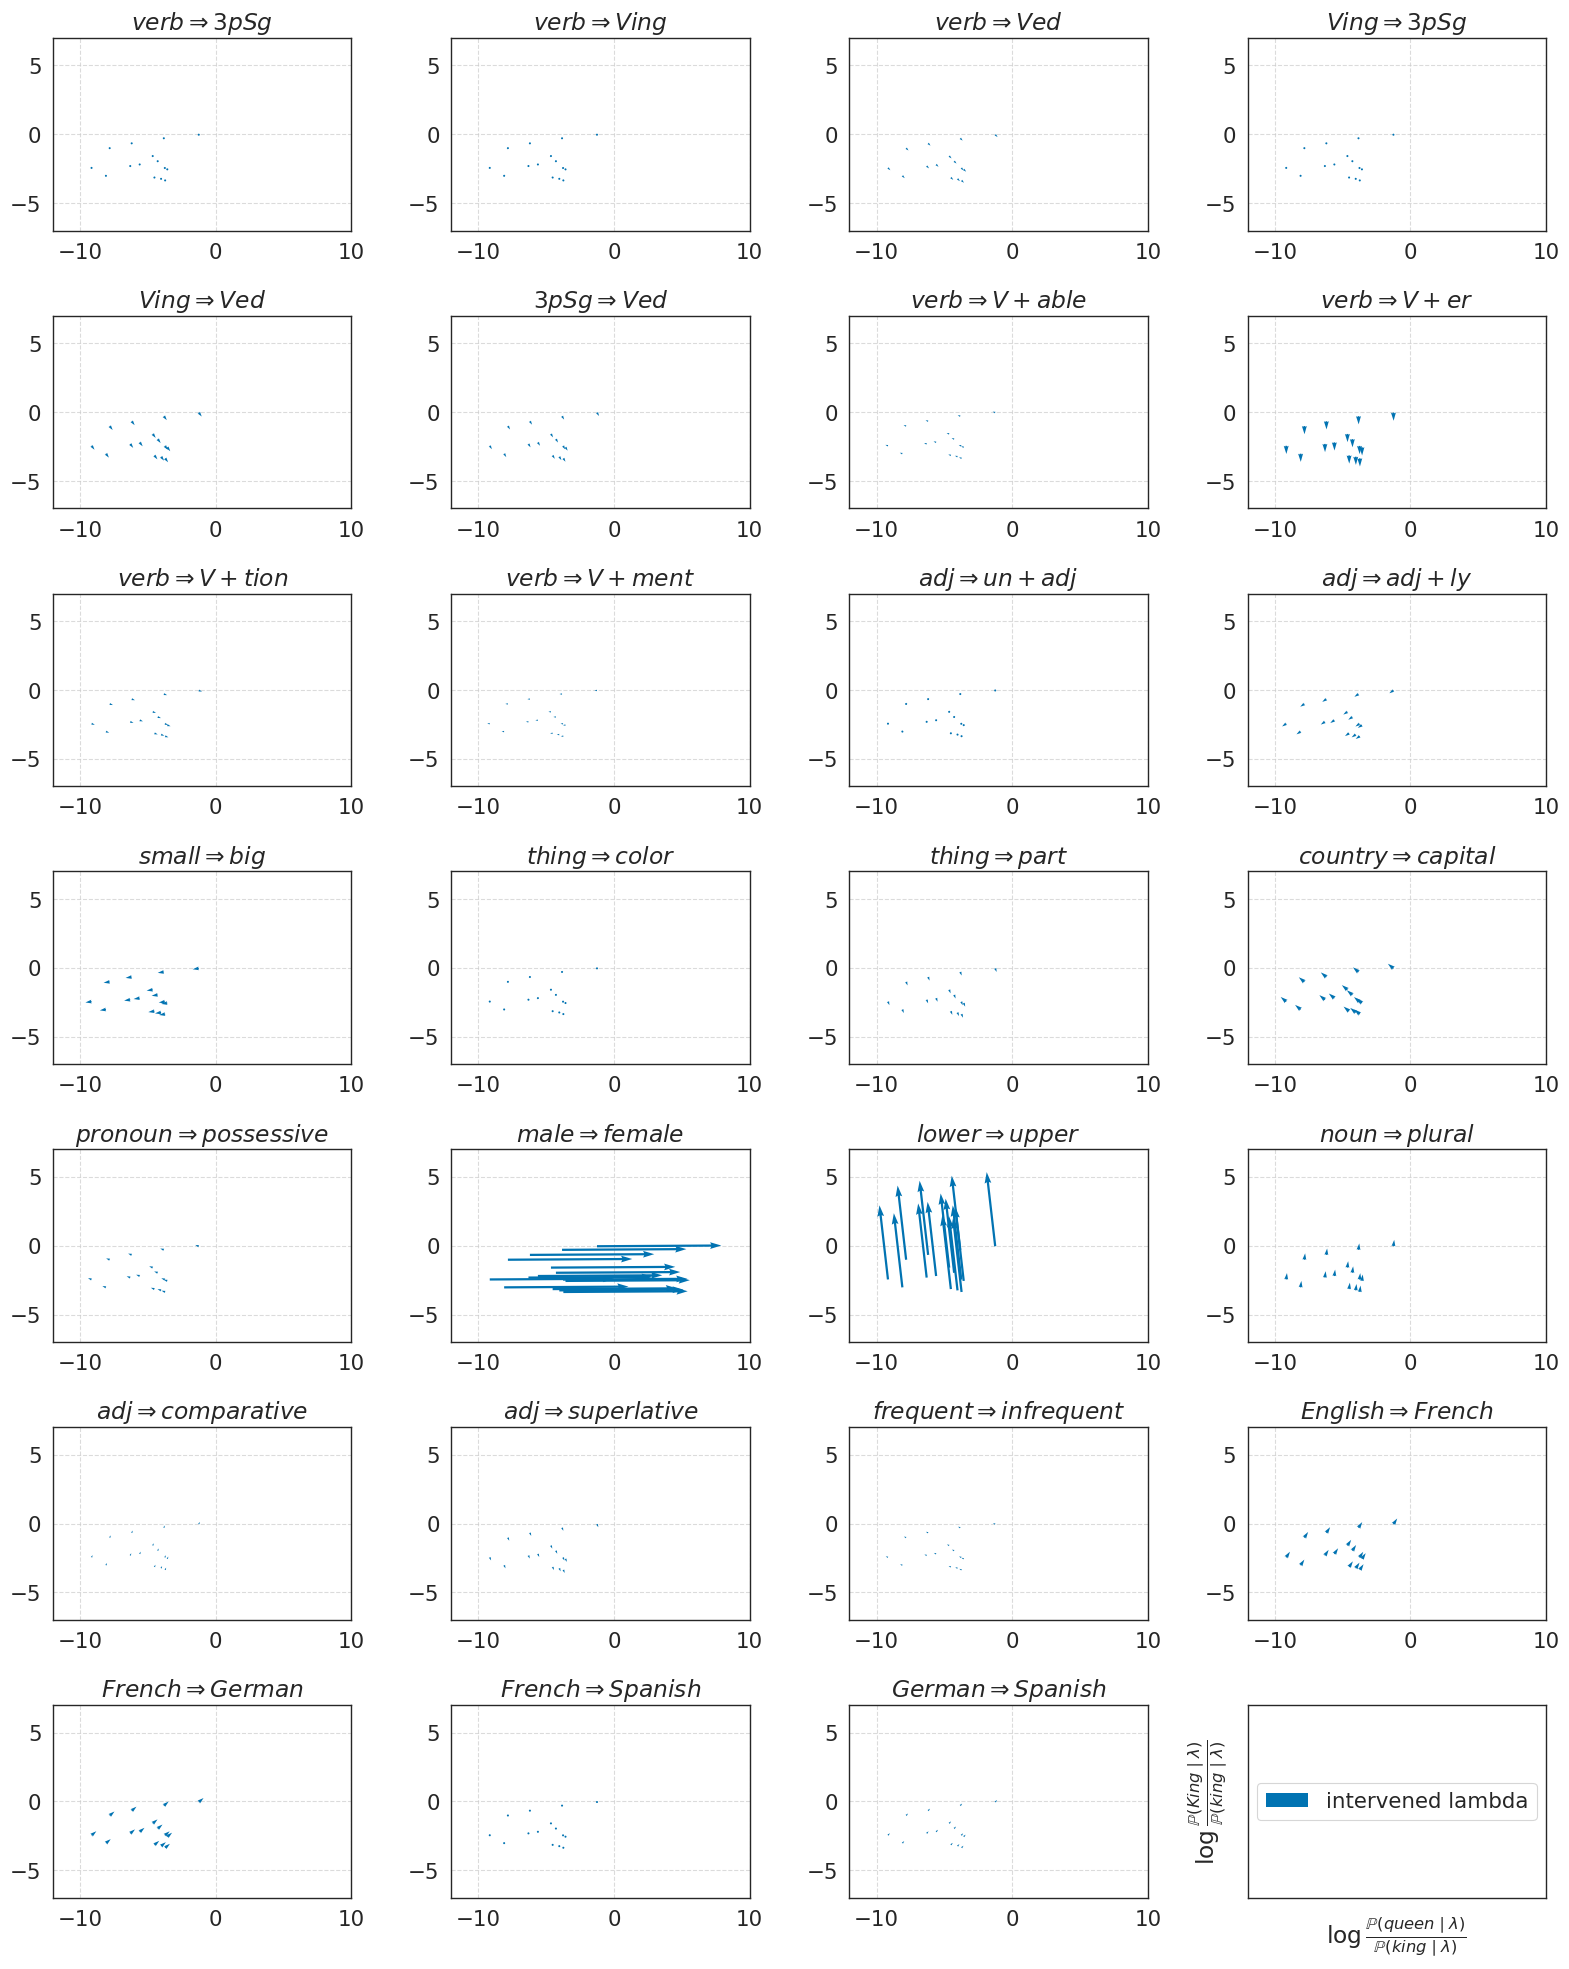

In [3]:
# lrg.show_intervention(l_batch, g, concept_g, concept_names,
#                         base = "king", W = "queen", Z = "King",
#                         alpha = 0.4, xlim =[-12, 10], ylim =[-7, 7], fig_name = "g")

In [4]:
# check rank of the words for the intervened lambda
lrg.show_rank(text_batch, l_batch, g, concept_g, which_ind = 0, concept_number = 17)

Prompt: Long live the
  &  0.0 & 0.1 & 0.2 & 0.3 & 0.4
1 & king & Queen & queen & queen & queen
2 & King & queen & Queen & Queen & Queen
3 & Queen & king &  & lady & lady
4 & queen & King & lady & woman & woman
5 &  &  & king & women & women


In [5]:
lrg.show_rank(text_batch, l_batch, g, concept_g, which_ind = 5, concept_number = 17)

Prompt: In a monarchy, the ruler is usually a
  &  0.0 & 0.1 & 0.2 & 0.3 & 0.4
1 & king & king & her & woman & woman
2 & monarch & monarch & monarch & queen & queen
3 & member & her & member & her & female
4 & her & member & woman & monarch & her
5 & person & person & queen & member & member
